In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./Task 3 and 4_Loan_Data.csv')
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


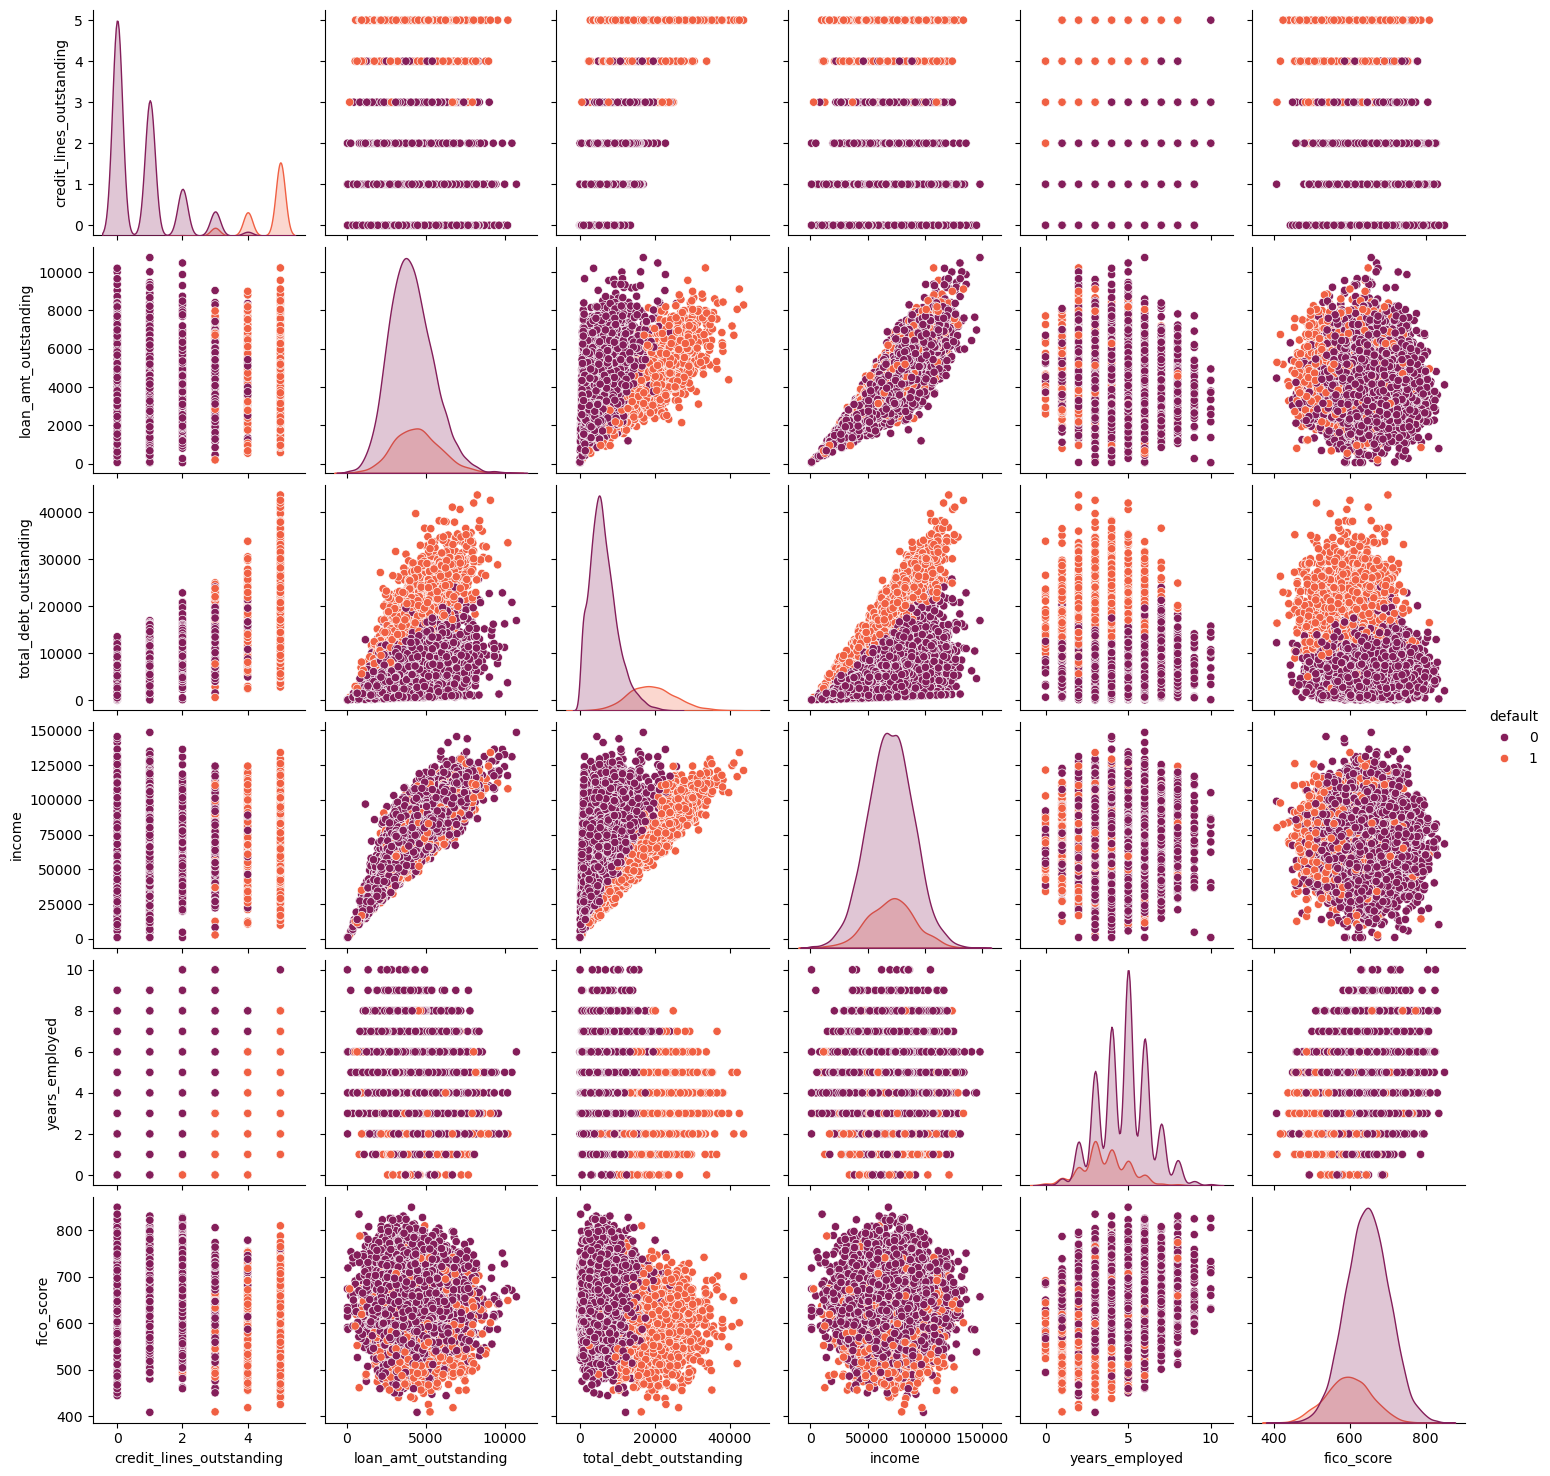

In [5]:
sns.pairplot(df.drop(columns = 'customer_id'), hue = "default",palette='rocket')
plt.show()


In [6]:
# Pair plot reveals some interesting and some obvious things

In [7]:
#getting more clarity 

In [8]:
from scipy.stats import pointbiserialr
corr_dict={}
for col in df.columns:
    if col != 'default' and col != 'customer_id':  # Exclude the target variable itself
        corr, _ = pointbiserialr(df[col], df['default'])
        corr_dict[col] = corr

corr= pd.DataFrame(corr_dict,index = [0])
corr


,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
0,0.862815,0.098978,0.758868,0.016309,-0.284506,-0.324515


## Model Selection

In [7]:
#scaling
from sklearn.preprocessing import StandardScaler
x = [col for col in df.columns if col != 'customer_id' and  col != 'default']
y = df['default'].to_numpy()
x = df[x].to_numpy()
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=.2, random_state= 42)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#log model 
log_model = LogisticRegression()
log_param = {'penalty':['l1', 'l2'],
     'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]}

GS_log = GridSearchCV(estimator= log_model,
                  param_grid= log_param ,
                  scoring='f1', 
                  refit= True, 
                  cv = 3, 
                  verbose = 1, 
                  n_jobs=-1) 
GS_log.fit(x_train,y_train)


In [57]:
GS_log.best_params_

{'learning_rate': 0.02,
 'loss': 'log_loss',
 'max_depth': 5,
 'n_estimators': 300}

In [17]:
log_model = LogisticRegression(C=10,max_iter=100,penalty='l1',solver= 'liblinear')
log_model.fit(x_train,y_train)
y2_pred = log_model.predict(x_test)
log_acc = accuracy_score(y_test,y2_pred)
print(f'accuracy:{log_acc}')

accuracy:0.999


### Creating a Function to Take Loan Inputs

In [39]:
df.columns

Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'default'],
      dtype='object')

In [18]:
def Expected_loan_loss(model,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score):
    input = pd.DataFrame ({
 'credit_lines_outstanding': credit_lines_outstanding,
 'loan_amt_outstanding': loan_amt_outstanding,
 'total_debt_outstanding': total_debt_outstanding,
 'income': income,
 'years_employed': years_employed,
 'fico_score': fico_score },index=[0])
    input.to_numpy()
    input = scaler.transform(input)
    default = model.predict(input)
    loss = loan_amt_outstanding *.9 # assuming that 10% is recovered 90% will be loss
    if default == 1:
        return print(f" Default Probable,Expected Loss: ${round(loss,2)}")
    else:#handles case where default is not probable but you still want to see the chances and loss
        return print("Default Not Probable")

In [53]:
df.head(25)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
5,4661159,0,5376.886873,7189.121298,85529.84591,2,697,0
6,8291909,1,3634.057471,7085.980095,68691.57707,6,722,0
7,4616950,4,3302.172238,13067.570210,50352.16821,3,545,1
8,3395789,0,2938.325123,1918.404472,53497.37754,4,676,0
9,4045948,0,5396.366774,5298.824524,92349.55399,2,447,0


In [19]:
Expected_loan_loss(model = log_model,credit_lines_outstanding=5,loan_amt_outstanding=1958.928726,total_debt_outstanding=8228.752520,income=26648.43525,years_employed=2,fico_score=572)

 Default Probable,Expected Loss: $1763.04


/opt/miniconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
